In [1]:
!pip install huggingface_hub transformers timm

  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.3 MB/s eta 0:00:00
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [46]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys
sys.path.append("../extraction_core/page_selection")
sys.path.append("../extraction_core/extraction")
sys.path.append("../extraction_core/")

In [48]:
import hvac
import os
client = hvac.Client(
    url="https://vault.lab.sspcloud.fr", token=os.environ["VAULT_TOKEN"]
)

secret = os.environ["VAULT_MOUNT"] + os.environ["VAULT_TOP_DIR"] + "/s3_creds"
mount_point, secret_path = secret.split("/", 1)
secret_dict = client.secrets.kv.read_secret_version(
    path=secret_path, mount_point=mount_point
)

os.environ["AWS_ACCESS_KEY_ID"] = secret_dict["data"]["data"][
    "ACCESS_KEY"
]
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict["data"]["data"][
    "SECRET_KEY"
]
try:
    del os.environ["AWS_SESSION_TOKEN"]
except KeyError:
    pass

In [122]:
from extraction.data import fs

fs.ls("projet-extraction-tableaux/orange/bmp")

['projet-extraction-tableaux/orange/bmp/306769688.bmp',
 'projet-extraction-tableaux/orange/bmp/307299248.bmp',
 'projet-extraction-tableaux/orange/bmp/345039416.bmp',
 'projet-extraction-tableaux/orange/bmp/379984891.bmp',
 'projet-extraction-tableaux/orange/bmp/380129866.bmp',
 'projet-extraction-tableaux/orange/bmp/384518114.bmp',
 'projet-extraction-tableaux/orange/bmp/409759156.bmp',
 'projet-extraction-tableaux/orange/bmp/430107359.bmp',
 'projet-extraction-tableaux/orange/bmp/432668432.bmp',
 'projet-extraction-tableaux/orange/bmp/440419240.bmp',
 'projet-extraction-tableaux/orange/bmp/500413505.bmp',
 'projet-extraction-tableaux/orange/bmp/500440813.bmp',
 'projet-extraction-tableaux/orange/bmp/501614572.bmp']

In [123]:
from pathlib import Path

for path in fs.ls("projet-extraction-tableaux/orange/bmp"):
    file_name = Path(path).stem
    fs.get(path, "../data/orange/" + file_name + ".bmp")

In [7]:
for path in fs.ls("projet-extraction-tableaux/orange/bmp"):
    file_name = Path(path).stem
    print(file_name)

306769688
307299248
345039416
379984891
380129866
384518114
409759156
430107359
432668432
440419240
500413505
500440813
501614572


In [171]:
from pathlib import Path
from PIL import Image
from huggingface_hub import hf_hub_download
from transformers import DetrFeatureExtractor, DetrImageProcessor, DetrForObjectDetection
from transformers import TableTransformerForObjectDetection
import torch
import pytesseract
from pytesseract import Output
from extraction.table_transformer_utils import *
from io import StringIO
import pandas as pd
from extraction.utils import get_root_path
from extraction.image_utils import *
import matplotlib.pyplot as plt

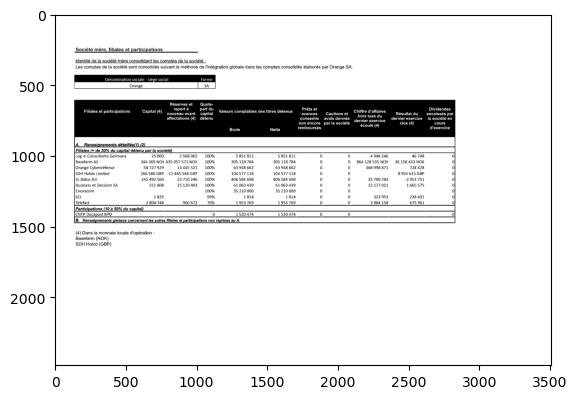

In [212]:
image = Image.open('../data/orange/345039416.bmp').convert("RGB")
image = to_bw(image)
plt.imshow(image)

In [207]:
def invert_dark_areas_v2(image):
    #img_bgr = cv2.imread(path)  # Read image as BGR
    img_bgr = image  # Read image as BGR
    
    img_grey = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # Convert from BGR to grayscale.
    
    thresh = 170
    img_binary_inv = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY_INV)[1]  # Apply threshold and invert black/white
    
    # Convert from BGR to HSV color space.
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # Get the saturation color channel - all black and white are zero, and colored pixels are above zero.
    s = hsv[:, :, 1]
    
    thresh = 100
    s_binary = cv2.threshold(s, thresh, 255, cv2.THRESH_BINARY)[1]  # Apply threshold to the saturation channel.
    
    # Find contours on s_binary
    cnts = cv2.findContours(s_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # Use index [-2] to be compatible to OpenCV 3 and 4
    
    # Draw the contours as white (255 values) on black background.
    mask = np.zeros_like(s_binary)
    cv2.drawContours(mask, cnts, -1, 255, -1)
    
    # Apply morphological closing for closing some black gaps.
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3)))
    
    # Get only the area inside the mask from img_binary_inv
    masked_binary_inv = cv2.bitwise_or(img_binary_inv, img_binary_inv, mask=mask)
    
    # Copy masked_binary_inv to img_grey only in pixels that mask is white.
    cv2.copyTo(masked_binary_inv, mask, img_grey)

    #cv2.imwrite(f'../data/orange/{siren}.png', img_grey)

    return img_grey

In [216]:
TEST_DATA = [
    #"306769688",
    #"344066733",
    "345039416",
    #"380129866",
    #"384518114",
    ##"409759156",
    #"432668432",
    #"440419240",
    #"500413505",
    #"307299248",
    #"379984891",
    #"430107359",
    #"500440813",
    #"501614572",
]
data_dir = "../data/orange"
test_images = [
    Path(data_dir).joinpath(path + ".png") for path in TEST_DATA
]

feature_extractor_detection= DetrImageProcessor.from_pretrained("TahaDouaji/detr-doc-table-detection")
detection_model = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection")

feature_extractor = DetrImageProcessor()
#detection_model = TableTransformerForObjectDetection.from_pretrained(
#    "microsoft/table-transformer-detection"
#)

structure_model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition"
)

# Paddings
left_padding = 20
top_padding = 50
right_padding = 20
bottom_padding = 50

# Dict
output = {}

for siren, image_path in zip(TEST_DATA, test_images):
    print(f"--- Siren {siren} ---")
    #invert_dark_areas_v2(f'../data/orange/{siren}.bmp')
    image = Image.open(f'../data/orange/{siren}.bmp').convert("RGB")
    width, height = image.size
    #image = to_bw(image)

    # Encoding for table detection
    encoding = feature_extractor_detection(image, return_tensors="pt")
    with torch.no_grad():
        outputs = detection_model(**encoding)
    results = feature_extractor.post_process_object_detection(
        outputs, threshold=0.7, target_sizes=[(height, width)]
    )[0]
    table_boxes = results["boxes"].tolist()

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
                f"Detected {detection_model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"
        )

    for table_idx, table_box in enumerate(table_boxes):
        print(f"--- Table {table_idx} ---")
        xmin, ymin, xmax, ymax = table_box
        # Cropped image (only detected table)
        resized_image = image.crop(
            (
                xmin - right_padding,
                ymin - top_padding,
                xmax + right_padding,
                ymax + bottom_padding,
            )
        )

        resized_image.save(f'../data/orange/{siren}_crop.png')

        # use numpy to convert the pil_image into a numpy array
        numpy_resized_image=np.array(resized_image)  
        
        # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that 
        # the color is converted from RGB to BGR format
        resized_image_bgr =cv2.cvtColor(numpy_resized_image, cv2.COLOR_RGB2BGR) 
        resized_image_bgr = invert_dark_areas_v2(resized_image_bgr)

        # from BGR to GRB
        resized_image = cv2.cvtColor(resized_image_bgr, cv2.COLOR_BGR2RGB)
        resized_image = Image.fromarray(resized_image)

        # Encoding for structure recognition
        encoding = feature_extractor(resized_image, return_tensors="pt")
        with torch.no_grad():
            outputs = structure_model(**encoding)

        target_sizes = [resized_image.size[::-1]]
        results = feature_extractor.post_process_object_detection(
            outputs, threshold=0.6, target_sizes=target_sizes
        )[0]

        # Getting tokens
        d = pytesseract.image_to_data(
            resized_image, output_type=Output.DICT
        )
        tokens = []
        n_boxes = len(d["level"])
        for i in range(n_boxes):
            (xmin, ymin, w, h) = (
                d["left"][i],
                d["top"][i],
                d["width"][i],
                d["height"][i],
            )
            xmax = xmin + w
            ymax = ymin + h
            text = d["text"][i]
            tokens.append({"bbox": [xmin, ymin, xmax, ymax], "text": text})
        # 'tokens' is a list of tokens
        # Need to be in a relative reading order
        # If no order is provided, use current order
        for idx, token in enumerate(tokens):
            if not "span_num" in token:
                token["span_num"] = idx
            if not "line_num" in token:
                token["line_num"] = 0
            if not "block_num" in token:
                token["block_num"] = 0

        # Post-process detected objects, assign class labels
        objects = results_to_objects(
            results, resized_image.size, str_class_idx2name
        )

        # Further process the detected objects so they correspond to a consistent table
        tables_structure = objects_to_structures(
            objects, tokens, structure_class_thresholds
        )

        # Enumerate all table cells: grid cells and spanning cells
        table_cells = [
            structure_to_cells(structure, tokens)[0]
            for structure in tables_structure
        ]

        table_csvs = [cells_to_csv(cells) for cells in table_cells]

        io = StringIO(table_csvs[0])
        df = pd.read_csv(io, sep=",")

        output[f'{siren}_{table_idx}'] = df

--- Siren 345039416 ---
Detected table with confidence 0.845 at location [123.64, 949.51, 2822.75, 1470.98]
Detected table with confidence 0.961 at location [110.45, 608.29, 2824.8, 1476.89]
--- Table 0 ---
--- Table 1 ---


In [217]:
output['345039416_0']

,Log In Consultants Germany,25 000,2 568 065,100%,5 851 811,5 851 811.1,[oO,Unnamed: 7,948 246,46 748
0,Basefarm AS,344 369 NOK,635 057 571 NOK,100%,305 118 784,305 118 784,NaN,864,128535NOK 36158 453,NOK
1,Orange Cyberdéfense,54 727 929,13 445 521,100%,63 948 662,63 948 662,NaN,368,998 871,724 428
2,SDH Holdo Limited,266 586 GBP,-11 445 544 GBP,100%,104 577 118,104 577 118,NaN,NaN,8 955,615 GBP
3,SL Bidco B.V,245 492 560,23 710 246,100%,406 584 698,406 584 698,NaN,35,700 783 -2,053 751
4,Business et Decision SA,551 808,25 120 403,100%,61 063 439,61 063 439,ooo0oo0o0c0.0,ooooooo0o;9o,22177021 1665,575
5,Enovacom,NaN,NaN,100%,35 210 000,35 210 000,NaN,NaN,NaN,NaN
6,SCI,1829,NaN,99%,1814,1814,NaN,NaN,323 953,238 691
7,Telefact,2 804 748,960 672,70%,1953 769,1953 769,oo,NaN,984 158,675 961


In [218]:
output['345039416_1']

,Filiales et participations,Capital (4),Réserves et | report a nouveau avant | affectations (4) |,Quote- part du capital détenu,Valeurs comptables des titres détenus |,Valeurs comptables des titres détenus | .1,Préts et avances consentis non encore remboursés,. Cautions et |avals donnés |par la société,Chiffre d’affaires hors taxe du dernier exercice écouleé (4),Résultat du dernier exercice clos (4),Dividendes encaissés par | la société en cours d’exercice
0,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2,A. Renseignements détaillés(1) (2
1,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...
2,Log In Consultants Germany,25 000,2 568 065,100%,5 851 811,5 851 811,[oO,NaN,4 948 246,46 748,NaN
3,Basefarm AS,344 369 NOK,635057571NOK,100%,305 118 784,305 118 784,NaN,NaN,864 128535NOK,36158 453 NOK,NaN
4,Orange Cyberdéfense,54 727 929,13 445 521,100%,63 948 662,63 948 662,ooo0oo0o0c0.0,ooooooo0o;9o,368 998 871,724 428,NaN
5,SDH Holdo Limited,266 586 GBP,-11 445 544 GBP,100%,104 577 118,104 577 118,NaN,NaN,NaN,8 955 615 GBP,NaN
6,SL Bidco B.V,245 492 560,23 710 246,100%,406 584 698,406 584 698,NaN,NaN,35 700 783,-2 053 751,NaN
7,Business et Decision SA,551 808,25 120 403,100%,61 063 439,61 063 439,NaN,NaN,22177021,1665 575,NaN
8,Enovacom,NaN,NaN,100%,35 210 000,35 210 000,NaN,NaN,NaN,NaN,NaN
9,SCI,1829,NaN,99%,1814,1814,NaN,NaN,323 953,238 691,NaN


In [203]:
output['345039416_2']

,Log In Consultants Germany,25 000,2 568 065,100%,5 851 811,5 851 811.1,0,Unnamed: 7,4 948 246,46 748
0,Basefarm AS,344 369 NOK,635 057 571 NOK,100%,305 118 784,305 118 784,0,NaN,864 128535NOK,36158 453 NOK
1,Orange Cyberdéfense,54 727 929,13 445 521,100%,63 948 662,63 948 662,0,ooooooo0o;9o,368 998 871,724 428
2,SDH Holdo Limited,266 586 GBP,-11 445 544 GBP,100%,104 577 118,104 577 118,0,NaN,NaN,8 955 615 GBP
3,SL Bidco B.V,245 492 560,23 710 246,100%,406 584 698,406 584 698,0,NaN,35 700 783,-2 053 751
4,Business et Decision SA,551 808,25 120 403,100%,61 063 439,61 063 439,0,NaN,22177021,1665 575
5,Enovacom,NaN,NaN,100%,35 210 000,35 210 000,0,NaN,NaN,NaN
6,SCI,1829,NaN,99%,1814,1814,0,NaN,323 953,238 691
7,Telefact,2 804 748,960 672,70%,1953 769,1953 769,0,NaN,3 984 158,675 961
